In [71]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# To build models
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

In [5]:
# get the data and consolidate it into one
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(train_df.shape, test_df.shape)

df = pd.concat([train_df, test_df])

df.shape

(7352, 563) (2947, 563)


(10299, 563)

In [6]:
df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


There are several features in the dataset, however we want to know the main categories of the features

In [7]:
features = df.columns.values.tolist()
unique_sensors = sorted(set([feature.split('-')[0] for feature in features]))
print(f'Sensors:')
for sensor in unique_sensors: print(sensor)
# print()

# for sensor in features: print(sensor)

Sensors:
Activity
angle(X,gravityMean)
angle(Y,gravityMean)
angle(Z,gravityMean)
angle(tBodyAccJerkMean),gravityMean)
angle(tBodyAccMean,gravity)
angle(tBodyGyroJerkMean,gravityMean)
angle(tBodyGyroMean,gravityMean)
fBodyAcc
fBodyAccJerk
fBodyAccMag
fBodyBodyAccJerkMag
fBodyBodyGyroJerkMag
fBodyBodyGyroMag
fBodyGyro
subject
tBodyAcc
tBodyAccJerk
tBodyAccJerkMag
tBodyAccMag
tBodyGyro
tBodyGyroJerk
tBodyGyroJerkMag
tBodyGyroMag
tGravityAcc
tGravityAccMag


Additionally, there is tBodyAcc... and fBodyAcc...

The prefix t stands for the time domain. The features are derived directly from the raw time-domain signals obtained from the smartphone's accelerometer.

The prefix f stands for the frequency domain. These features are derived by applying a Fast Fourier Transform to the time domain signals. Allows for the analysis of the frequency components of the acceleration signals.

In [8]:
# print(df.shape[0])
# plt.plot(df['fBodyAcc-mean()-X'].values, df)

# df['tBodyAcc-mean()-X'].plot()

# plt.show()

# plt.show()

In [9]:
# Checking in case there is any duplicated column in both train and test
df.columns.duplicated().sum()

0

In [10]:
# selected_df = df[selected_features]
# selected_df['subject'] = df['subject']
# selected_df['Activity'] = df['Activity']

# features = selected_df.columns.values.tolist()
# unique_sensors = sorted(set([feature.split('-')[0] for feature in features]))
# print(f'Sensors:')
# for sensor in unique_sensors: print(sensor)
# selected_df.shape

In [11]:
# See the different types of activities across both train and test
unique_activities = df['Activity'].unique()
print(f'In entire dataset: {unique_activities}')

unique_activities_train = train_df['Activity'].unique()
print(f'In train set: {unique_activities_train}')

In entire dataset: ['STANDING' 'SITTING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']
In train set: ['STANDING' 'SITTING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


Hence we see a mix of equi-level movelement (walking), no movement (standing, sitting, laying), and multi-level movement (walking downstairs, walking upstairs). Logic tells us that regarding position, equi-level movement will have less rise in altitude compared to using the stairs. Also, stationary activities such as sitting, standing, and laying will have less impact on motion data, and should be generally more separable than motion-based activities.

In [12]:
# checking the dimensions of each dataframe for reference
print(f'Total: {df.shape}\nTrain set: {train_df.shape}\nTest set: {test_df.shape}')

Total: (10299, 563)
Train set: (7352, 563)
Test set: (2947, 563)


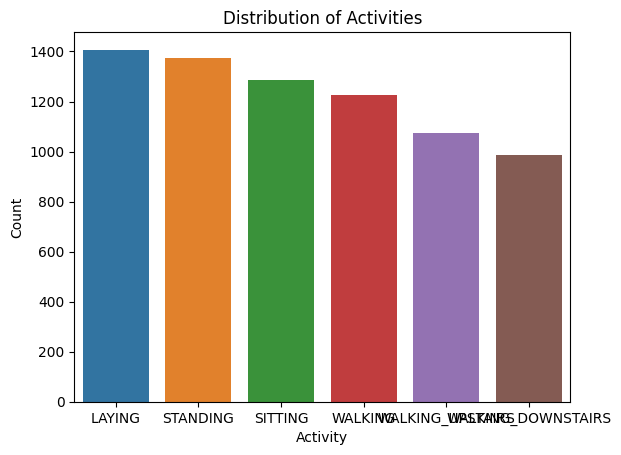

In [13]:
# Check the distribution of the activities
val_counts = train_df['Activity'].value_counts()

# plotting distribution
sns.barplot(x=val_counts.index, y=val_counts.values)
plt.title('Distribution of Activities')
plt.ylabel('Count')
plt.xlabel('Activity')
plt.show()

Laying is the most popular activity. Not super surprising.

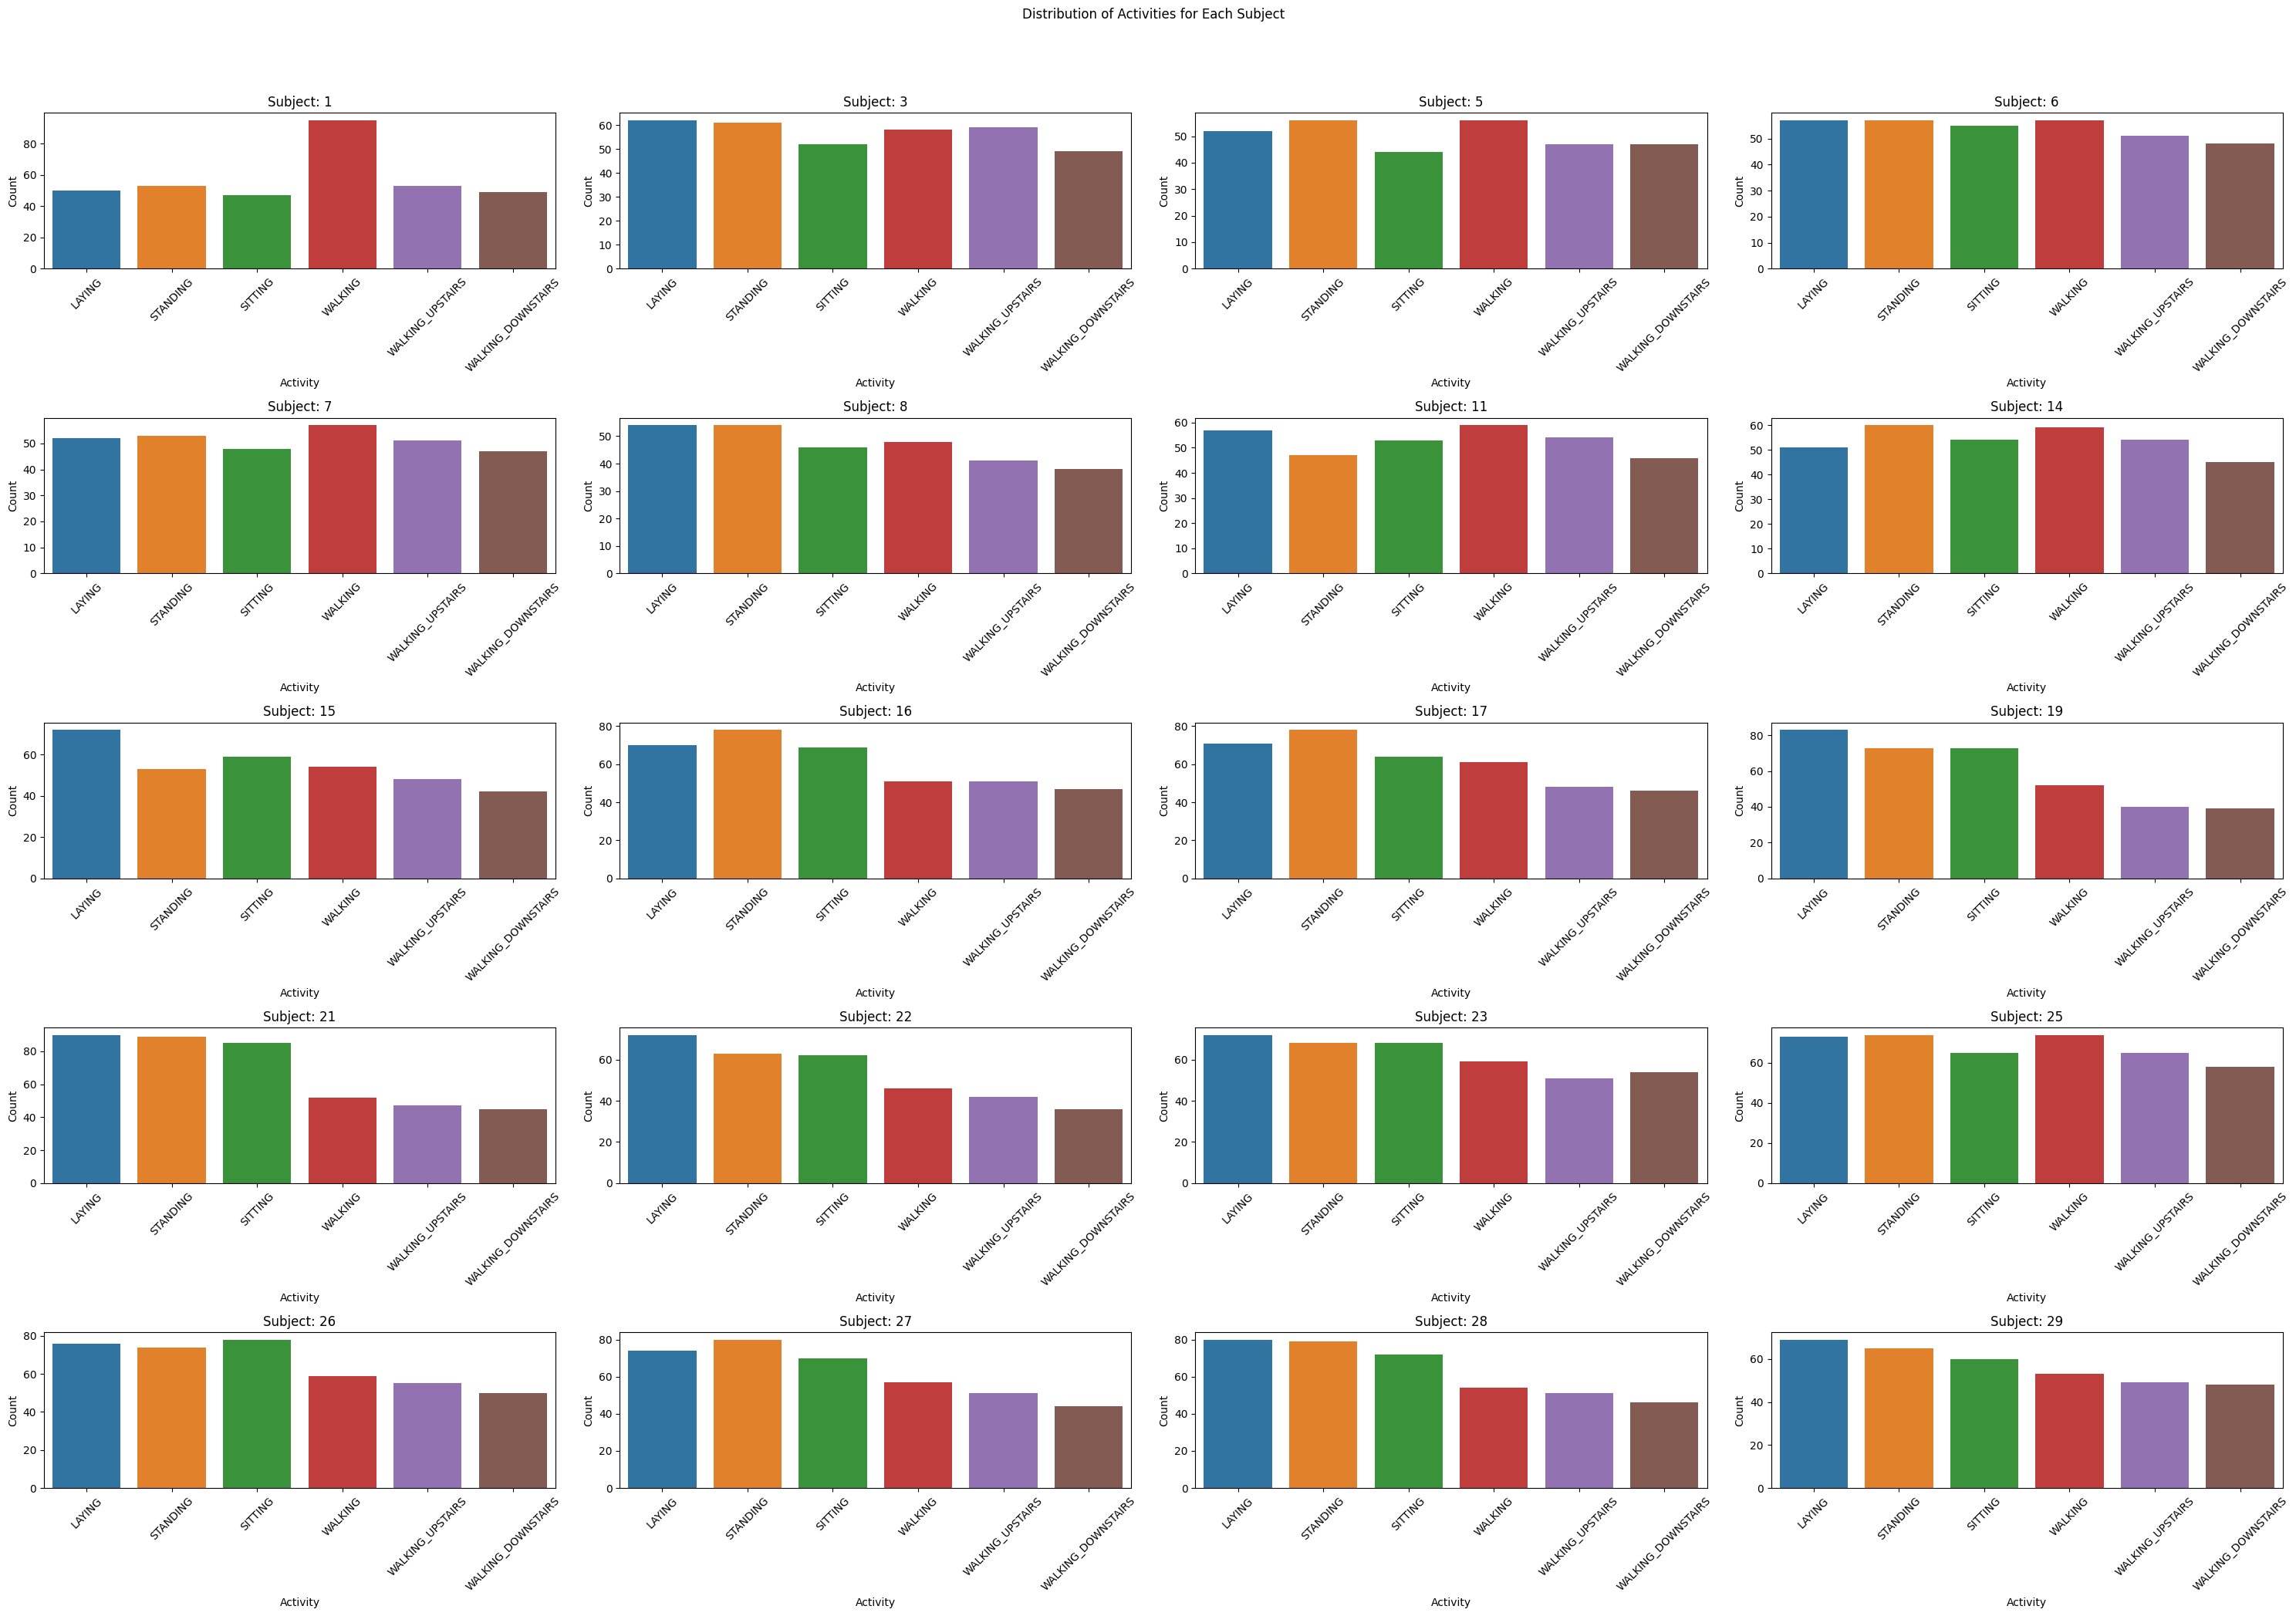

In [14]:
unique_subjects = train_df['subject'].unique()
n_subjects = len(unique_subjects)
rows = math.ceil(n_subjects / 5)
cols = 4

# Order the activities beforehand so that they are in the same order every time
activity_order = train_df['Activity'].value_counts().index.tolist()

fig, axes = plt.subplots(rows, cols, figsize=(30, 22))
fig.suptitle('Distribution of Activities for Each Subject')

for i, ax in enumerate(axes.flatten()):
    if i < n_subjects:
        # Filter the DataFrame for the current subject
        subject_df = train_df[train_df['subject'] == unique_subjects[i]]

        # Plotting the histogram with a consistent activity order
        sns.barplot(x=subject_df['Activity'].value_counts().index,
                    y=subject_df['Activity'].value_counts().values,
                    order=activity_order,  # Use the global order
                    ax=ax)

        ax.set_title(f'Subject: {unique_subjects[i]}')
        ax.set_xlabel('Activity')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_ylabel('Count')
    else:
        fig.delaxes(ax)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


These plots represent the activity each subject has done. From this plot, we can confirm that each subject in this experiment were subjected to every single activity.

In [15]:
subject_row_counts = train_df.groupby('subject').size()

print(subject_row_counts)

subject_row_counts_df = subject_row_counts.reset_index(name='Count')
# print(subject_row_counts_df)

subject
1     347
3     341
5     302
6     325
7     308
8     281
11    316
14    323
15    328
16    366
17    368
19    360
21    408
22    321
23    372
25    409
26    392
27    376
28    382
29    344
30    383
dtype: int64


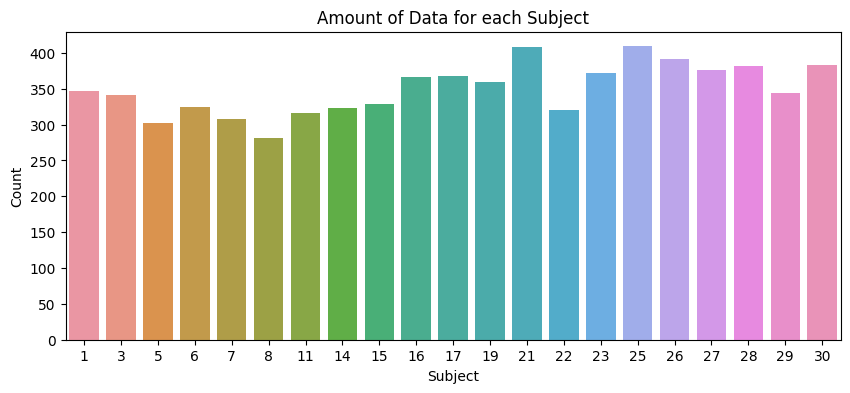

In [16]:
plt.figure(figsize=(10, 4))
sns.barplot(x=subject_row_counts_df['subject'].values, y=subject_row_counts_df['Count'].values)
plt.title('Amount of Data for each Subject')
plt.ylabel('Count')
plt.xlabel('Subject')
plt.show()

In [17]:
train_df.shape

(7352, 563)

Since the data is time series data, it would be valuable to see how the sensor data for one subject would look. Let us visualize the sensor data for one subject

<Figure size 2000x1600 with 0 Axes>

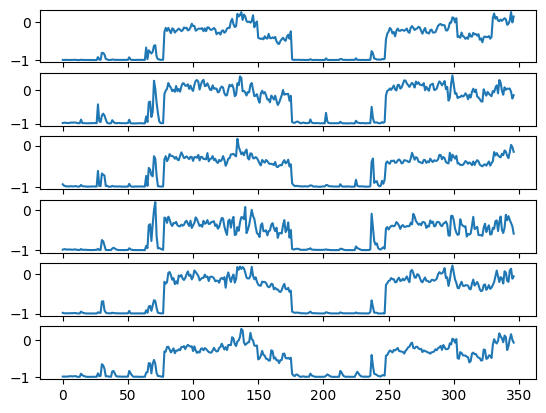

In [18]:
subject1_df = train_df[train_df['subject'] == 1]

set_sensors = ('fBodyAcc-mean()-X', 'fBodyAcc-mean()-Y', 'fBodyAcc-mean()-Z', 'fBodyGyro-mean()-X', 'fBodyGyro-mean()-Y', 'fBodyGyro-mean()-Z')

plt.figure(figsize=(20, 16))
fig, axs = plt.subplots(len(set_sensors))

for i, sensor in enumerate(set_sensors):
  subject1_df[sensor].plot(ax=axs[i])

This graph shows us the values from the accelerometer and gyroscope sensors. However, it would be more helpeful to see what activity each section of the line coorelates to.

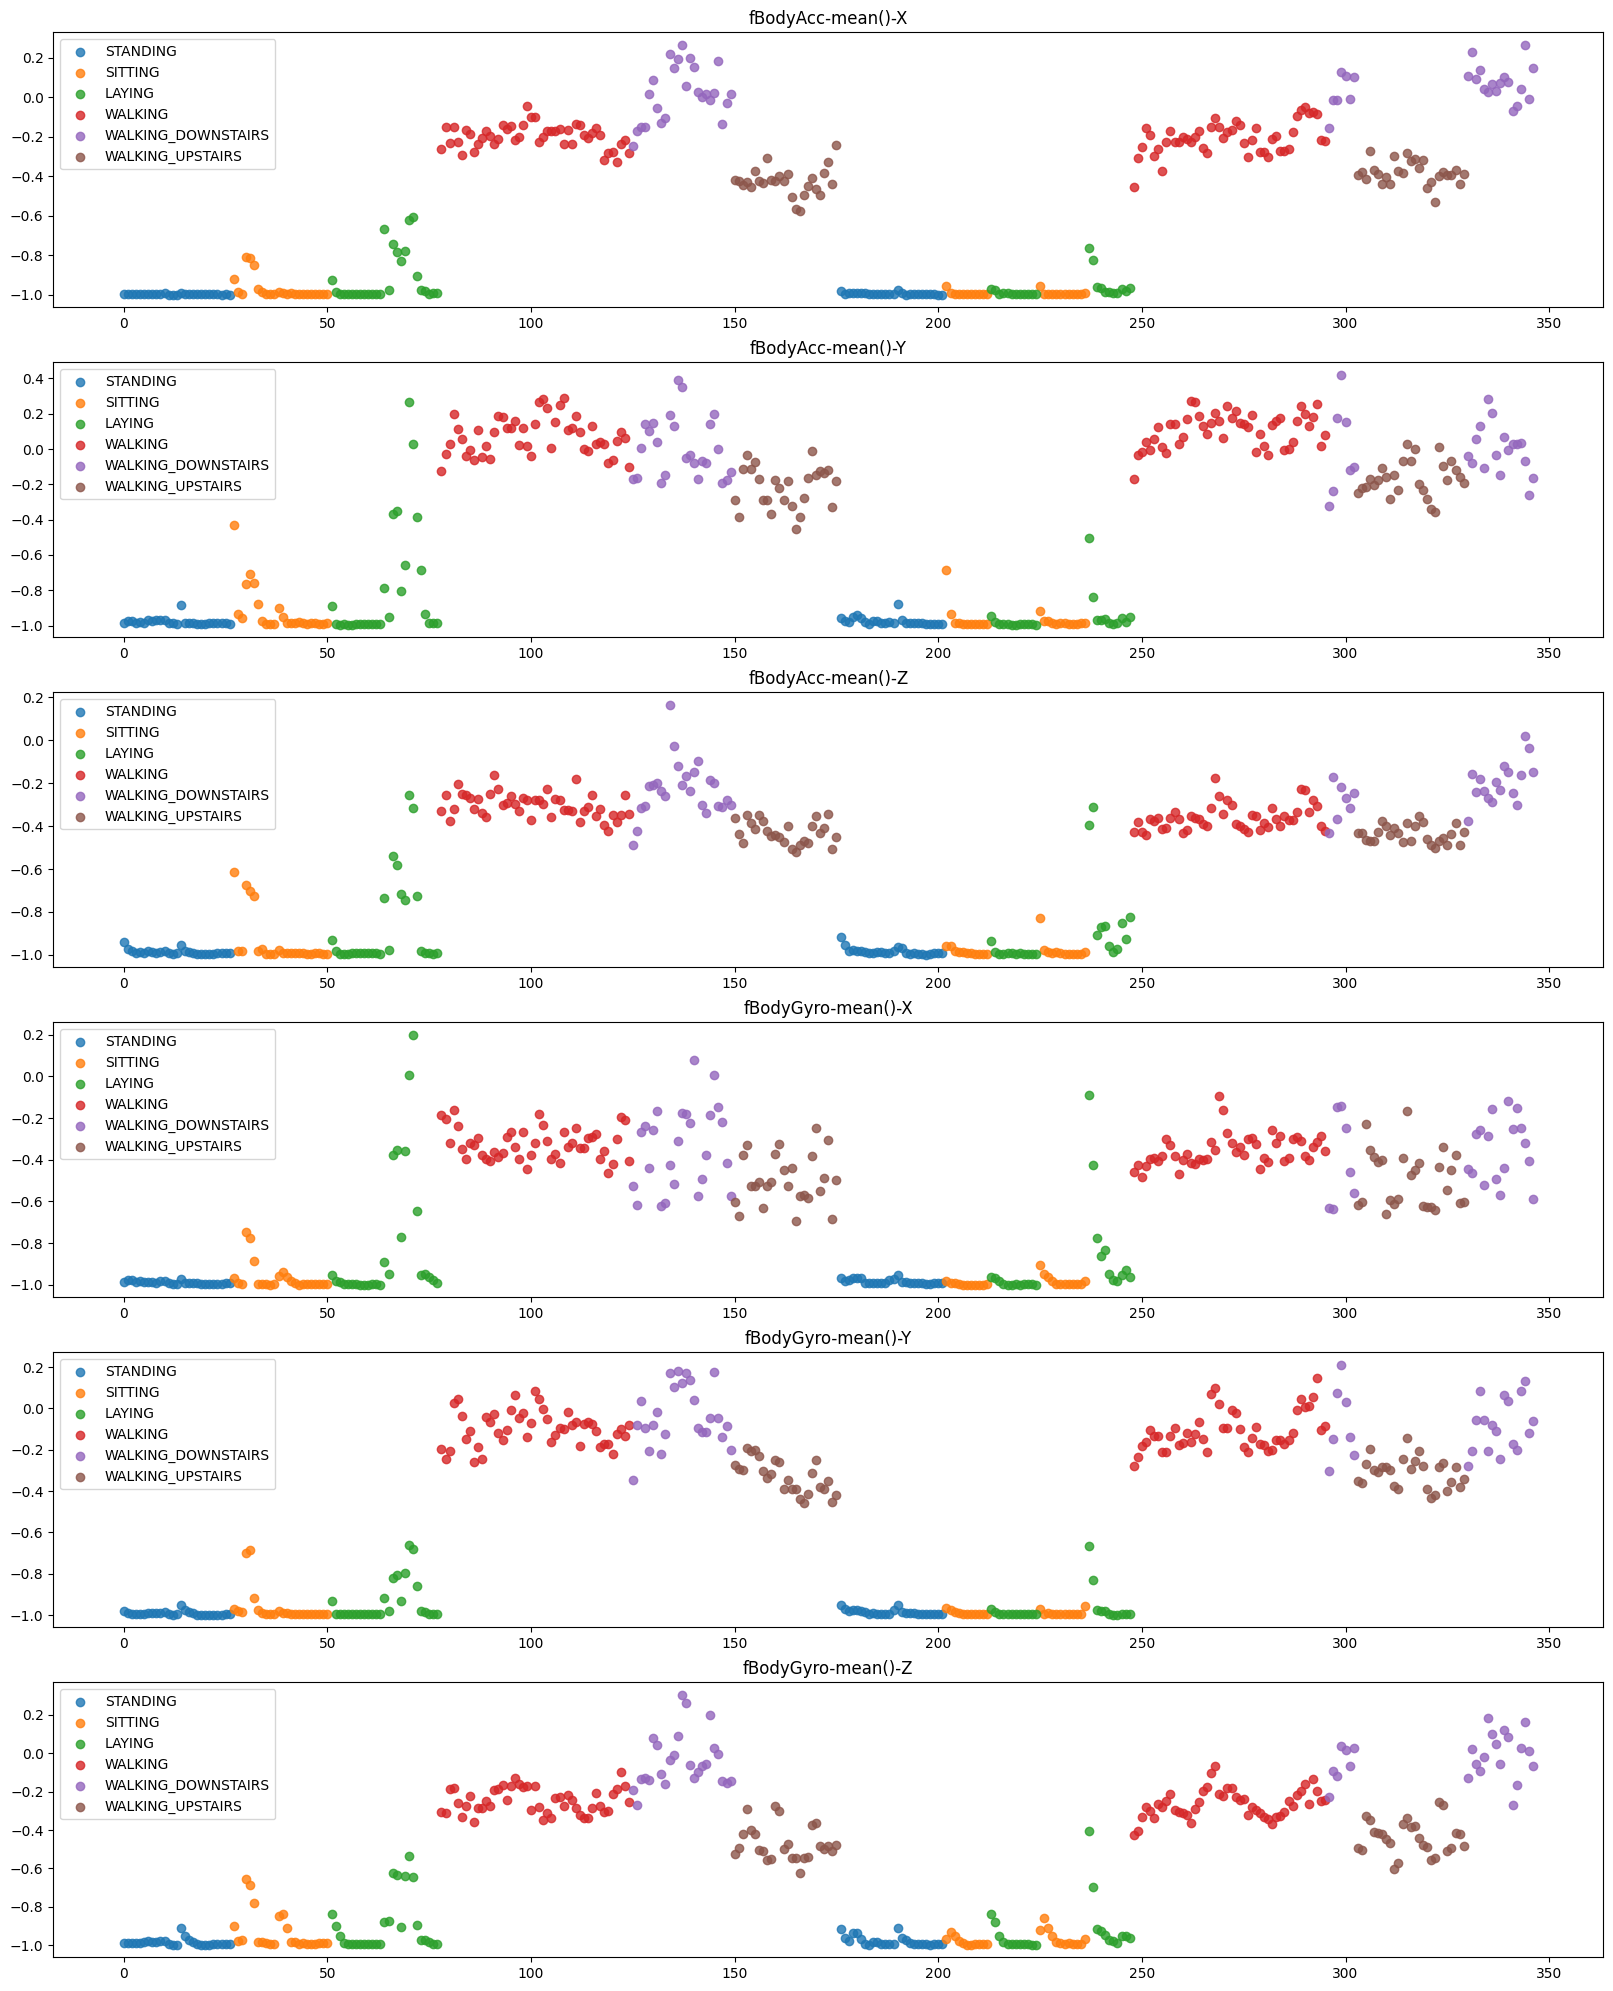

In [19]:
fig, axs = plt.subplots(len(set_sensors), figsize=(20, 25))

for i, sensor in enumerate(set_sensors):
    axs[i].set_title(sensor)
    for activity in subject1_df['Activity'].unique():
        activity_df = subject1_df[subject1_df['Activity'] == activity]
        axs[i].scatter(activity_df.index, activity_df[sensor], label=activity, alpha=0.8)  # alpha for transparency
    axs[i].legend()

plt.show()

From the above graph, we can visually discern a good distinction between activities based on where the data points lie on the graph. However, as seen from the visualizations, motion information is not significantly useful. We can better visualize this.

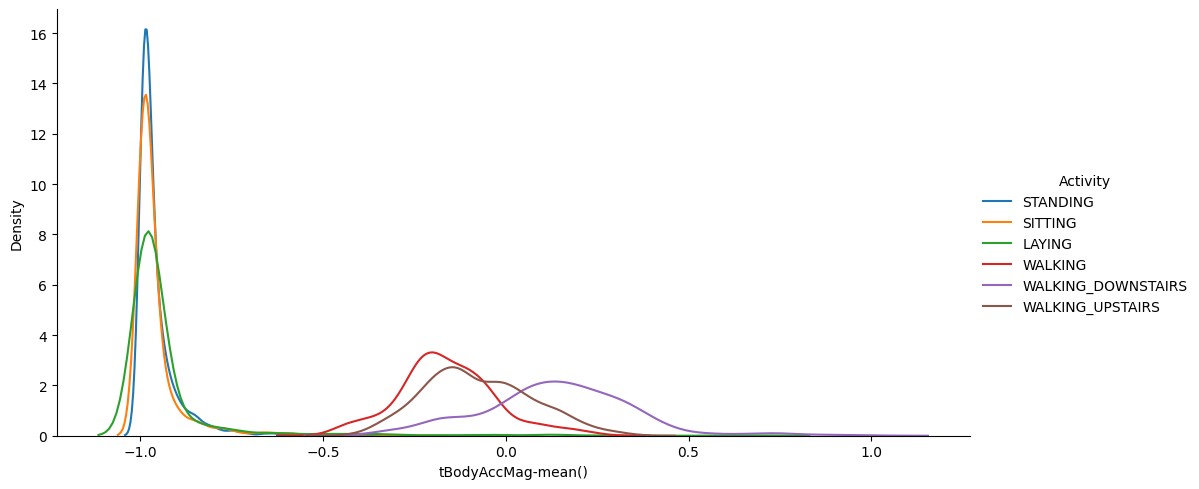

In [20]:
facetgrid = sns.FacetGrid(train_df, hue='Activity', height=5,aspect=2)
facetgrid.map(sns.kdeplot,'tBodyAccMag-mean()')\
    .add_legend()
plt.show()

We need to visualize if the activities are separable, so that models can effectively learn from the data. WE can use t-distributed stochastic neighbor encoding for this, a popular dimensionality reduction algorithm for visualizing high-dimensional data.

T-SNE, also known as T-distributed Stochastic Neighbor Embedding, is a powerful tool designed for visualizing high-dimensional data. It excels in mapping multi-dimensional data to lower dimensions while maintaining the relative distances between data points, thus facilitating the visualization of complex data structures.

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.007s...
[t-SNE] Computed neighbors for 7352 samples in 1.730s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.469101
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.586594
[t-SNE] KL divergence after 1000 iterations: 1.262295


<Axes: >

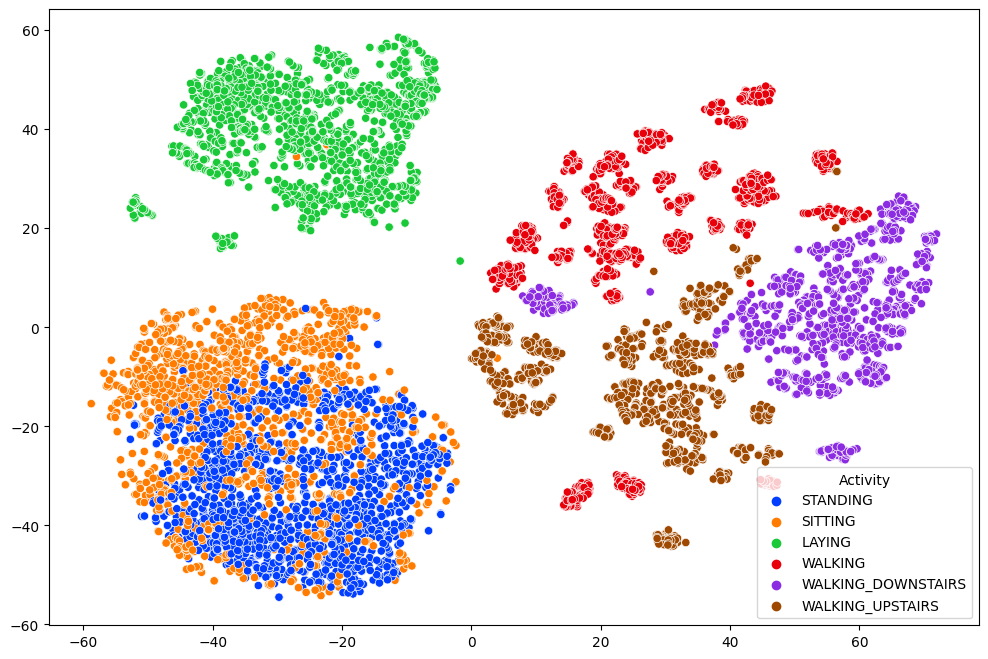

In [ ]:
X_train_tsne = train_df.drop(['subject','Activity'], axis = 1)
tsne = TSNE(random_state = 42, verbose = 1, perplexity = 60, n_iter = 1000).fit_transform(X_train_tsne)

plt.figure(figsize = (12,8))
sns.scatterplot(x = tsne[:,0], y = tsne[:,1], hue = train_df["Activity"], palette = "bright")

From this observation,the data suggests distinct groupings based on both posture and movement:

* The laying cluster is well separated from the others, reflecting its unique characteristics as a posture. Overall, it involves minimal movement.

* The walking, walking upstairs/downstairs are intermingled, yet each forms its own sub-cluster. While they are similar in nature,which involves some form of movement, they have distinct features that can be discerned.

* The standing and sitting datapoints are grouped together but also show clear sub-clustering, which indicates that while they are considered stationary activities, they also have distinguishable attributes. Sitting activity may show less variability in the data due to the more constrained nature of the posture compared to standing, which may involve small, subtle movements like weight shifting.

Next, we need to conduct preprocessing and feature engineering

## Data Preprocessing

The chosen data preprocessing techniques for this specific task are Principal Component Analysis (PCA) and standardize scaling, each offering unique benefits in data analysis and visualization.

- Principal Component Analysis (PCA) is a linear dimensionality reduction method employed to decrease the dimensionality of the dataset, focusing on preserving the most informative aspects. This technique identifies and selects the most significant features based on the variance they introduce in the outcome, which is important for understanding the data's underlying structure. By reducing the number of features, PCA significantly cuts down the training time of algorithms, enhancing efficiency without compromising the integrity of the data.



## Encoding the categorial activity values




In [21]:
train_df_encoded = train_df.copy()
train_labels = train_df_encoded.pop('Activity')

test_df_encoded = test_df.copy()
test_labels = test_df_encoded.pop('Activity')

# Fit the encoder
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)

train_labels_encoded = label_encoder.transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

train_df['Activity'] = train_labels_encoded
test_df['Activity'] = test_labels_encoded

## Dimensionality Reduction


In [23]:
selected_X = train_df.drop('Activity', axis=1)
selected_y = train_df['Activity']

k = 550
select = SelectKBest(f_classif, k=k)
X_train_select = select.fit_transform(selected_X, selected_y)


selected_i = select.get_support(indices=True)
selected_features= selected_X.columns[selected_i]
print(f'Number of selected features: {len(selected_features)}')
print(selected_features)

selected_train_df = train_df[selected_features]
selected_train_df['Activity'] = train_df['Activity']

selected_test_df = test_df[selected_features]
selected_test_df['Activity'] = test_df['Activity']

Number of selected features: 550
Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-std()-X',
       'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X',
       'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X',
       'tBodyAcc-max()-Y',
       ...
       'fBodyBodyGyroJerkMag-iqr()', 'fBodyBodyGyroJerkMag-entropy()',
       'fBodyBodyGyroJerkMag-maxInds', 'fBodyBodyGyroJerkMag-meanFreq()',
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyGyroMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)'],
      dtype='object', length=550)


/var/folders/82/9grvh10d16b9p8x6_59j949w0000gn/T/ipykernel_42579/2204054162.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/82/9grvh10d16b9p8x6_59j949w0000gn/T/ipykernel_42579/2204054162.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The Feature selection implementation selects the top k feeatures and extracts them from the dataframe. The use of SelectkBest is mainly to reduce the number of features based on their statistical relationshoip with the target variable. By reducing the dimensions before PCA, it can become more managable and efficient for predictions.

## Dimensionality Reduction


Conducting Principle Component Analysis to reduce dimensionality, ordered by the amount of variance they explain in the data. We have chosen to retain 98.8% of the variation of the data, which brings us from 561 features down to 240 features. We found this to provide the best results in model performance. 

In [24]:
train_df_pca = selected_train_df.copy()
train_df_pca = train_df_pca.drop('Activity', axis=1)

print(train_df_pca.shape)
pca = PCA(n_components=0.998, random_state = 1)
train_df_pca = pca.fit_transform(train_df_pca)
print(train_df_pca.shape)
train_df_pca = pd.DataFrame(train_df_pca)

# test_df.head()

test_df_pca = selected_test_df.drop('Activity', axis=1)
test_df_pca = pca.transform(test_df_pca)
print(test_df_pca.shape)
test_df_pca = pd.DataFrame(test_df_pca)

(7352, 550)
(7352, 240)
(2947, 240)


In [25]:
X_train = train_df_pca
# y_train = pd.DataFrame(train_labels_encoded)
y_train = train_labels_encoded

X_test = test_df_pca
# y_test = pd.DataFrame(test_labels_encoded)
y_test = test_labels_encoded

# X_train = train_df.drop(['Activity', 'subject'], axis = 1)
# # y_train = pd.DataFrame(train_labels_encoded)
# y_train = train_labels_encoded

# X_test = test_df.drop(['Activity', 'subject'], axis = 1)
# # y_test = pd.DataFrame(test_labels_encoded)
# y_test = test_labels_encoded

Scaling the data

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## DIFFERENT CLASSIFIERS

In [28]:
rf = RandomForestClassifier(criterion='entropy')
rf.fit(X_train, y_train)

# print(f'Cross Validation:\n{cross_val_score(rf, X_train, y_train, cv=5)}')

y_pred_rf = rf.predict(X_test)

print("Testing Accuracy", accuracy_score(y_test, y_pred_rf))

Testing Accuracy 0.9131319986426875


In [29]:
svc = SVC()

svc.fit(X_train, y_train)

# print(f'Cross Validation:\n{cross_val_score(svc, X_train, y_train, cv=5)}')

y_pred_svc = svc.predict(X_test)

print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred_svc)))

Model accuracy score with default hyperparameters: 0.9518


In [30]:
model = XGBClassifier(n_jobs=2)
model.fit(X_train, y_train)

# print(f'Cross Validation:\n{cross_val_score(model, X_train, y_train, cv=5)}')

y_pred_xgboost = model.predict(X_test)

print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred_xgboost)))

Model accuracy score with default hyperparameters: 0.9277


## Neural Networks:

In [31]:
clf = MLPClassifier(solver='adam', alpha=1e-08, hidden_layer_sizes=(25, 10,), activation='tanh', random_state=2, batch_size='auto')
clf.fit(X_train, y_train)

print(f'Cross Validation:\n{cross_val_score(clf, X_train, y_train, cv=5)}')

y_pred_clf = clf.predict(X_test)

print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred_clf)))

Cross Validation:
[0.92590075 0.90754589 0.94013605 0.95918367 0.9707483 ]
Model accuracy score with default hyperparameters: 0.9627


## Viewing model performance and results

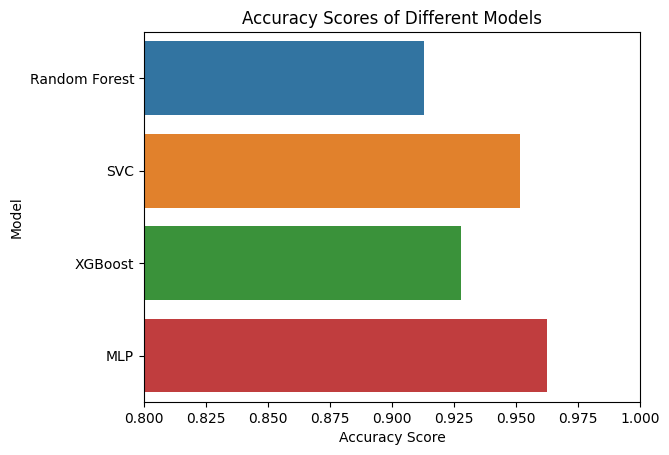

,Model,Score
0,Random Forest,0.913132
1,SVC,0.951815
2,XGBoost,0.927723
3,MLP,0.962674


In [32]:
# Make a pandas table containing the accuracy scores of every model
# and sort them in descending order
models = pd.DataFrame({
    'Model': ['Random Forest', 'SVC', 'XGBoost', 'MLP'],
    'Score': [accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_svc), accuracy_score(y_test, y_pred_xgboost), accuracy_score(y_test, y_pred_clf)]
})
models.sort_values(by='Score', ascending=False)

# Plot the accuracy scores and set the x linits from 0.8 to 1
sns.barplot(x='Score', y='Model', data=models)
plt.title('Accuracy Scores of Different Models')

plt.xlim(0.8, 1.0)

plt.xlabel('Accuracy Score')
plt.ylabel('Model')
plt.show()

models

We can also see the precision, recall, and f1 score of these classifiers. We also visualized the confusion matrix of the activity classifications. From the results, we can see that SVC and MLP's f1 scores are generally higher, indicating a better balance of precision and recall.  

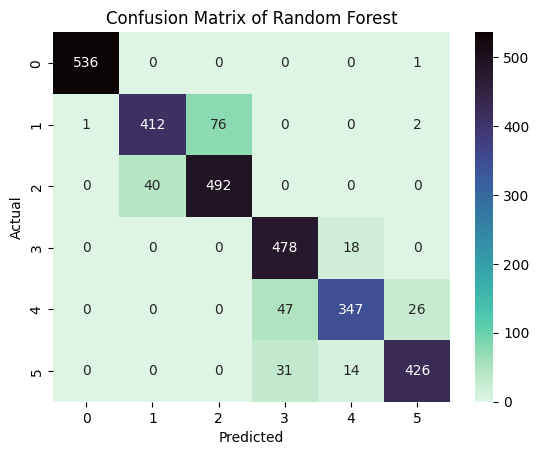

Classification report for random forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.91      0.84      0.87       491
           2       0.87      0.92      0.89       532
           3       0.86      0.96      0.91       496
           4       0.92      0.83      0.87       420
           5       0.94      0.90      0.92       471

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



In [97]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='mako_r')
plt.title('Confusion Matrix of Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f'Classification report for random forest:\n{classification_report(y_test, y_pred_rf)}')

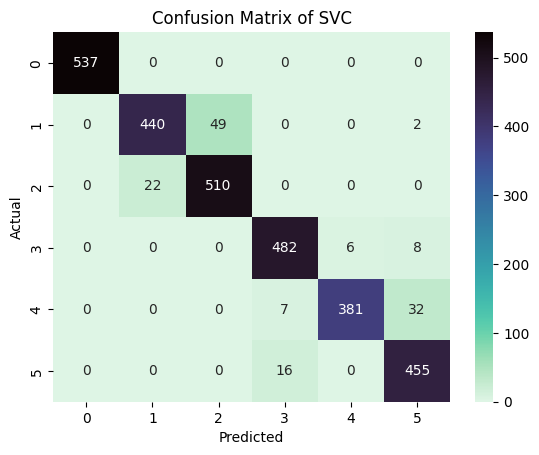

Classification report for SVC:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.95      0.90      0.92       491
           2       0.91      0.96      0.93       532
           3       0.95      0.97      0.96       496
           4       0.98      0.91      0.94       420
           5       0.92      0.97      0.94       471

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



In [98]:
cm = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm, annot=True, fmt='d', cmap='mako_r')
plt.title('Confusion Matrix of SVC')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f'Classification report for SVC:\n{classification_report(y_test, y_pred_svc)}')

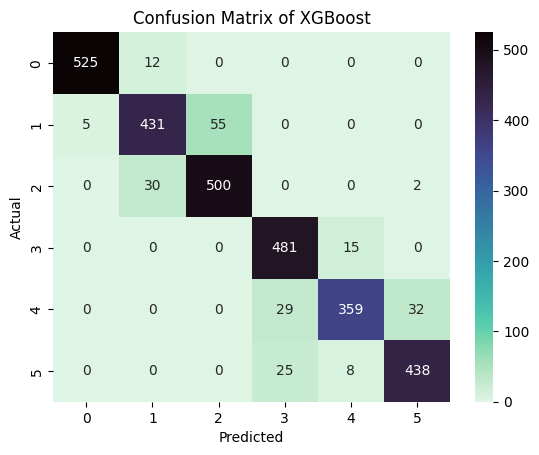

Classification report for XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       537
           1       0.91      0.88      0.89       491
           2       0.90      0.94      0.92       532
           3       0.90      0.97      0.93       496
           4       0.94      0.85      0.90       420
           5       0.93      0.93      0.93       471

    accuracy                           0.93      2947
   macro avg       0.93      0.92      0.93      2947
weighted avg       0.93      0.93      0.93      2947



In [99]:
cm = confusion_matrix(y_test, y_pred_xgboost)
sns.heatmap(cm, annot=True, fmt='d', cmap='mako_r')
plt.title('Confusion Matrix of XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f'Classification report for XGBoost:\n{classification_report(y_test, y_pred_xgboost)}')

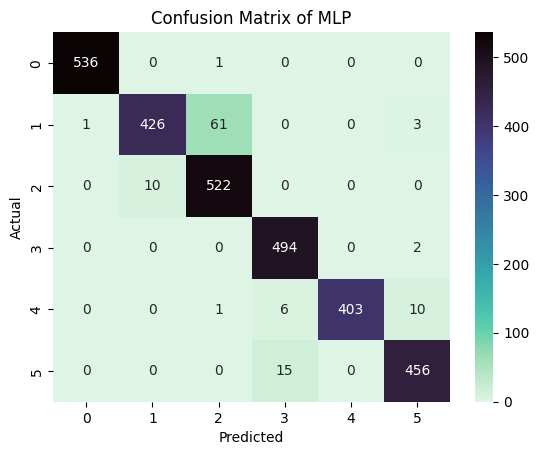

Classification report for MLP:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.98      0.87      0.92       491
           2       0.89      0.98      0.93       532
           3       0.96      1.00      0.98       496
           4       1.00      0.96      0.98       420
           5       0.97      0.97      0.97       471

    accuracy                           0.96      2947
   macro avg       0.97      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



In [100]:
cm = confusion_matrix(y_test, y_pred_clf)
sns.heatmap(cm, annot=True, fmt='d', cmap='mako_r')
plt.title('Confusion Matrix of MLP')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f'Classification report for MLP:\n{classification_report(y_test, y_pred_clf)}')

## Hyperparameter tuning

In [47]:
# Grid search for Random Forest model
parameters = {'criterion' : ['gini', 'entropy'],
              'min_samples_split': [2, 3, 4],
              'max_depth': [None, 10, 50, 100, 200],
              'max_features': ["sqrt", "log2"]
             }

gridClf = GridSearchCV(RandomForestClassifier(), parameters, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
gridClf.fit(X_train_scaled, y_train)

print("Grid search for random forest completed.")
print("\nHere are the best parameters for Random Forest:", gridClf.best_params_, "\n")

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Grid search for random forest completed.

Here are the best parameters for Random Forest: {'criterion': 'entropy', 'max_depth': 200, 'max_features': 'sqrt', 'min_samples_split': 4} 



In [33]:
# Define the parameter grid for SVC
parameters = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 0.1, 1],
    'class_weight': [None, 'balanced']
}

gridClf = GridSearchCV(SVC(), parameters, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
gridClf.fit(X_train, y_train)

print("Grid search for SVC completed.")
print("\nHere are the best parameters for SVC:", gridClf.best_params_, "\n")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Grid search for SVC completed.

Here are the best parameters for SVC: {'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'} 



In [55]:
# Define the parameter grid for XGBoost
parameters = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.2],
    'max_depth': [3, 6],
    'gamma': [0, 0.1],
    'subsample': [0.75, 1],
    'colsample_bytree': [0.75, 1],
}

gridClf = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), parameters, cv=3, scoring='accuracy', verbose=1, n_jobs=-1).fit(X_train_scaled, y_train)

print("Grid search for XGBoost completed.")
print("\nHere are the best parameters for XGBoost:", gridClf.best_params_, "\n")

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Grid search for XGBoost completed.

Here are the best parameters for XGBoost: {'colsample_bytree': 0.75, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.75} 



In [52]:
# Grid search for Multilayer Perceptron model
parameters = {
    'solver': ['adam'],
    'activation': ['relu', 'tanh', 'identity'],
    'hidden_layer_sizes': [(10, 10, 10), (100, 10, 50), (25, 10), (15, 10)],
    'alpha': [0.0001, 0.005, 1e-08],
    'learning_rate': ['adaptive', 'invscaling']
}

gridClf = GridSearchCV(MLPClassifier(), parameters, cv=3, scoring='accuracy', verbose=1, n_jobs=-1).fit(X_train, y_train)
print("Grid search completed.")

print("\nHere are the best parameters for MLP:",gridClf.best_params_,"\n")

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multi

Grid search completed.

Here are the best parameters for MLP: {'activation': 'relu', 'alpha': 1e-08, 'hidden_layer_sizes': (15, 10), 'learning_rate': 'invscaling', 'solver': 'adam'} 



# Creating models with the best parameters returned from grid search

In [68]:
# Random forest
forest_tuned = RandomForestClassifier(criterion='entropy', max_depth=200, max_features='sqrt', min_samples_split=4).fit(X_train_scaled, y_train)

tuned_forest_preds = forest_tuned.predict(X_test_scaled)
print(f'Tuned Forest model accuracy score on test data:\n{accuracy_score(y_test, tuned_forest_preds):.4f}\n')

Tuned Forest model accuracy score on test data:
0.9128



In [64]:
# SVC
svc_tuned = SVC(C=10, class_weight=None, gamma='scale', kernel='linear').fit(X_train, y_train)

tuned_svc_preds = svc_tuned.predict(X_test)
print(f'Tuned SVC model accuracy score on test data:\n{accuracy_score(y_test, tuned_svc_preds):.4f}\n')

Tuned SVC model accuracy score on test data:
0.9640



In [43]:
#XGBoost
XGB_tuned = XGBClassifier(colsample_bytree=0.75, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.75, use_label_encoder=False, eval_metric='mlogloss').fit(X_train_scaled, y_train)

tuned_XGB_preds = XGB_tuned.predict(X_test_scaled)
print(f'Tuned XGBoost model accuracy score on test data:\n{accuracy_score(y_test, tuned_XGB_preds):.4f}\n')

Tuned XGBoost model accuracy score on test data:
0.9440



In [60]:
# Multilayer Perceptron
tuned_mlp_clf = MLPClassifier(activation='relu', alpha=1e-08, hidden_layer_sizes=(15, 10), learning_rate='invscaling', solver='adam').fit(X_train, y_train).fit(X_train, y_train)

tuned_predictions_mlp = tuned_mlp_clf.predict(X_test)
print(f'Tuned MLP Classifier accuracy score on test data:\n{accuracy_score(y_test, tuned_predictions_mlp):.4f}\n')

Tuned MLP Classifier accuracy score on test data:
0.9684



## Comparison between tuned and untuned models

In [69]:
models = pd.DataFrame({
    'Model': ['Random Forest', 'SVC', 'XGBoost', 'MLP'],
    'Untuned Score': [accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_svc), accuracy_score(y_test, y_pred_xgboost), accuracy_score(y_test, y_pred_clf)],
    'Tuned Score': [accuracy_score(y_test, tuned_forest_preds), accuracy_score(y_test, tuned_svc_preds), accuracy_score(y_test, tuned_XGB_preds), accuracy_score(y_test, tuned_predictions_mlp)]
})
models.sort_values(by='Tuned Score', ascending=False)

,Model,Untuned Score,Tuned Score
3,MLP,0.962674,0.968442
1,SVC,0.951815,0.964031
2,XGBoost,0.927723,0.944011
0,Random Forest,0.913132,0.912793


As we can see from the above resultant table, several models were significantly improved through hyperparameter tuning. 